<a href="https://colab.research.google.com/github/adetayomathew1/learning_and_modeling_chaos/blob/main/Lorenz_System_Prediction_RC_vs_RNN_vs_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install reservoirpy tensorflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.8/208.8 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.7/119.7 kB 5.4 MB/s eta 0:00:00


/usr/local/lib/python3.11/dist-packages/scipy/integrate/_ivp/ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `initial_state`, `sampling_rate`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)
Running Model-0:   0%|          | 0/1 [00:00<?, ?it/s]
Running Model-0: 523it [00:00, 5228.96it/s]           
Running Model-0: 1054it [00:00, 5268.51it/s]
Running Model-0: 1581it [00:00, 5217.28it/s]
Running Model-0: 2103it [00:00, 5033.51it/s]
Running Model-0: 2622it [00:00, 5088.07it/s]
Running Model-0: 3132it [00:00, 4875.06it/s]
Running Model-0: 3622it [00:00, 4468.56it/s]
Running Model-0: 4162it [00:00, 4738.07it/s]
Running Model-0: 4686it [00:00, 4883.69it/s]
Running Model-0: 5207it [00:01, 4977.98it/s]
Running Model-0: 5714it [00:01, 5003.60it/s]
Running Model-0: 6236it [00:01, 5066.41it/s]
Running Model-0: 6999it [00:01, 4967.29it/s]
Running Model-0: 100%|██████████| 1/1 [00:01<00:00,  1.44s/it]


Fitting node Ridge-0...


Running Model-0: 2999it [00:00, 5034.68it/s]
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Reservoir Computing MSE: 0.024252866938777175
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
RNN MSE: 0.2128345270828207


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
LSTM MSE: 0.019680152763965838


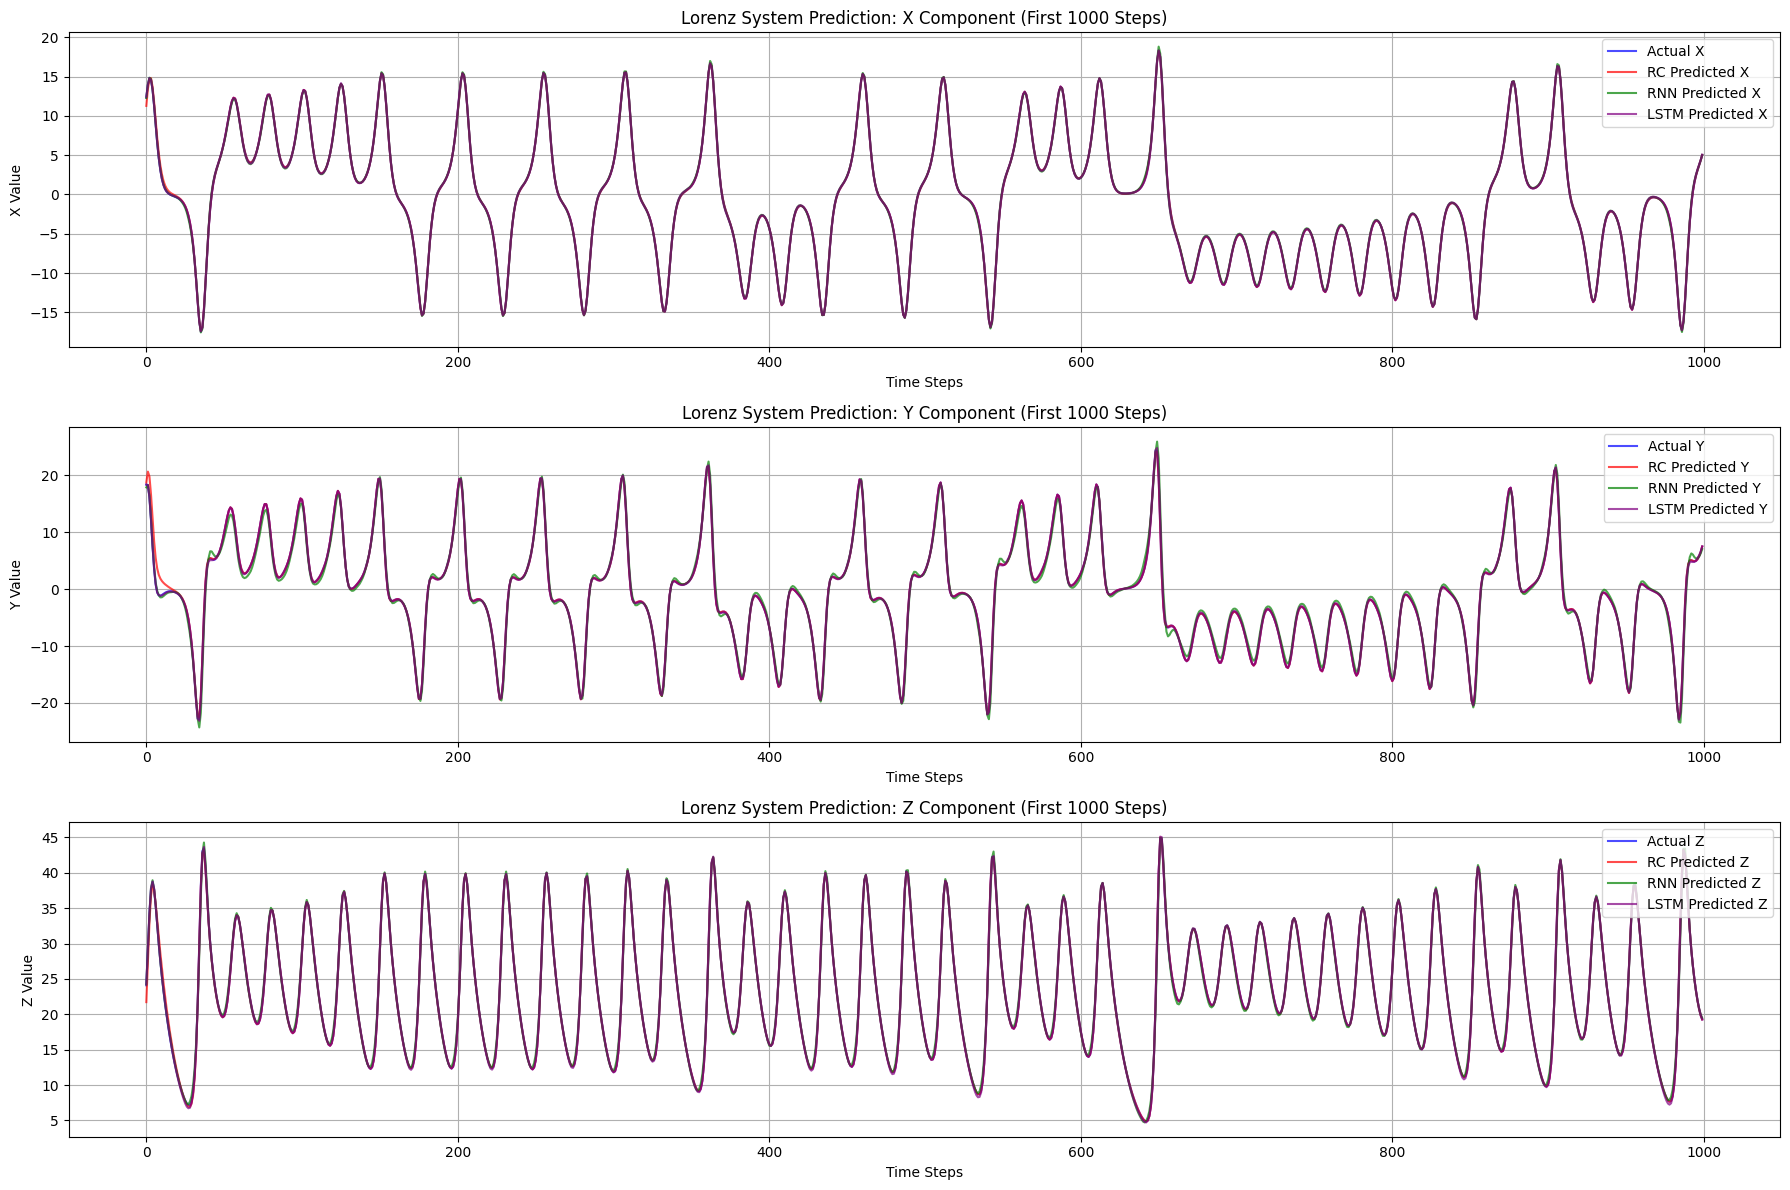

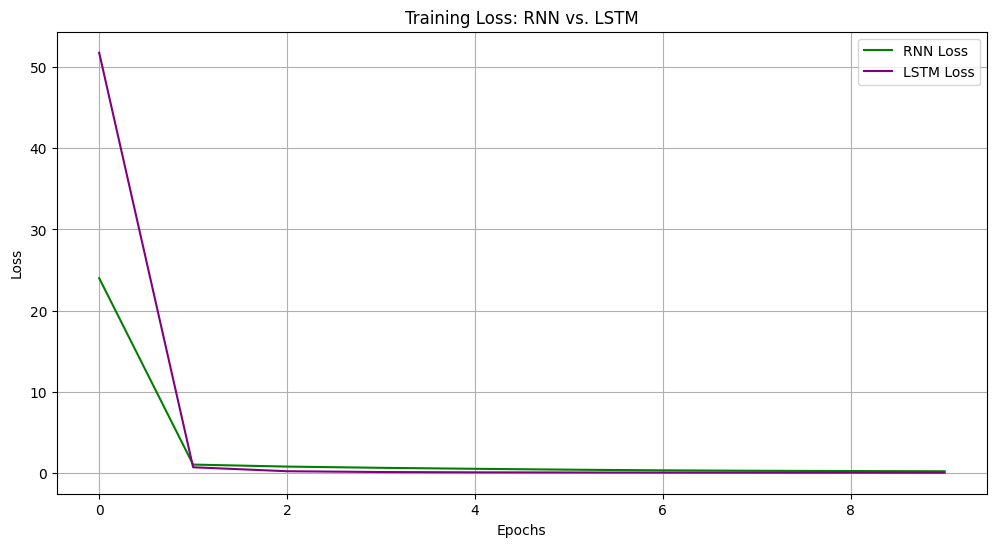

RC  MSE: 0.0243
RNN MSE: 0.2128
LSTM MSE: 0.0197


In [2]:
"""Enhanced Reservoir Computing for Lorenz System Prediction"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from reservoirpy.nodes import Reservoir, Ridge
from reservoirpy.datasets import lorenz

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense
from tensorflow.keras.callbacks import History  # Import History


# 1. Parameters for the Lorenz system
sigma = 10
beta = 8/3
rho = 28
initial_state = [0.1, 0.1, 0.1]
timesteps = 10000
sampling_rate = 0.01

# 2. Generate Lorenz data
lorenz_data = lorenz(timesteps, sigma=sigma, beta=beta, rho=rho,
                     initial_state=initial_state, sampling_rate=sampling_rate)

# 3. Split data into training and testing sets (70-30 split)
train_data, test_data = train_test_split(lorenz_data, test_size=0.3, shuffle=False)
X_train, y_train = train_data[:-1], train_data[1:]
X_test, y_test = test_data[:-1], test_data[1:]

# Function to reshape data for RNN/LSTM
def reshape_data(data):
    return data.reshape((data.shape[0], 1, data.shape[1]))

X_train_rnn = reshape_data(X_train)
X_test_rnn = reshape_data(X_test)


# 4. Reservoir Computing Model
# -----------------------------
reservoir = Reservoir(units=200, lr=0.2, sr=0.9, input_scaling=0.1, seed=42)
output_rc = Ridge(ridge=1e-6)
rc_model = reservoir >> output_rc
rc_model.fit(X_train, y_train)
predictions_rc = rc_model.run(X_test)
mse_rc = mean_squared_error(y_test, predictions_rc)
print(f"Reservoir Computing MSE: {mse_rc}")


# 5. RNN Model
# -----------
rnn_model = Sequential([
    SimpleRNN(units=128, activation='relu', input_shape=(1, 3)),
    Dense(3)  # Output layer with 3 units for x, y, z
])
rnn_model.compile(optimizer='adam', loss='mse')
rnn_history = History()  # Create a History object to store training loss
rnn_model.fit(X_train_rnn, y_train, epochs=10, verbose=0, callbacks=[rnn_history])
predictions_rnn = rnn_model.predict(X_test_rnn)
mse_rnn = mean_squared_error(y_test, predictions_rnn)
print(f"RNN MSE: {mse_rnn}")


# 6. LSTM Model
# ------------
lstm_model = Sequential([
    LSTM(units=128, activation='relu', input_shape=(1, 3)),
    Dense(3)
])
lstm_model.compile(optimizer='adam', loss='mse')
lstm_history = History() # Create a History object to store training loss
lstm_model.fit(X_train_rnn, y_train, epochs=10, verbose=0, callbacks=[lstm_history])
predictions_lstm = lstm_model.predict(X_test_rnn)
mse_lstm = mean_squared_error(y_test, predictions_lstm)
print(f"LSTM MSE: {mse_lstm}")



# 7. Plotting and Comparison
# --------------------------
plt.figure(figsize=(18, 12))  # Increased figure height to accommodate more plots

# X component
plt.subplot(3, 1, 1)
plt.plot(np.arange(1000), y_test[:1000, 0], label='Actual X', color='blue', alpha=0.7)
plt.plot(np.arange(1000), predictions_rc[:1000, 0], label='RC Predicted X', color='red', alpha=0.7)
plt.plot(np.arange(1000), predictions_rnn[:1000, 0], label='RNN Predicted X', color='green', alpha=0.7)
plt.plot(np.arange(1000), predictions_lstm[:1000, 0], label='LSTM Predicted X', color='purple', alpha=0.7)
plt.ylabel('X Value')
plt.xlabel('Time Steps')
plt.title('Lorenz System Prediction: X Component (First 1000 Steps)')
plt.legend()
plt.grid(True)

# Y component
plt.subplot(3, 1, 2)
plt.plot(np.arange(1000), y_test[:1000, 1], label='Actual Y', color='blue', alpha=0.7)
plt.plot(np.arange(1000), predictions_rc[:1000, 1], label='RC Predicted Y', color='red', alpha=0.7)
plt.plot(np.arange(1000), predictions_rnn[:1000, 1], label='RNN Predicted Y', color='green', alpha=0.7)
plt.plot(np.arange(1000), predictions_lstm[:1000, 1], label='LSTM Predicted Y', color='purple', alpha=0.7)
plt.ylabel('Y Value')
plt.xlabel('Time Steps')
plt.title('Lorenz System Prediction: Y Component (First 1000 Steps)')
plt.legend()
plt.grid(True)

# Z component
plt.subplot(3, 1, 3)
plt.plot(np.arange(1000), y_test[:1000, 2], label='Actual Z', color='blue', alpha=0.7)
plt.plot(np.arange(1000), predictions_rc[:1000, 2], label='RC Predicted Z', color='red', alpha=0.7)
plt.plot(np.arange(1000), predictions_rnn[:1000, 2], label='RNN Predicted Z', color='green', alpha=0.7)
plt.plot(np.arange(1000), predictions_lstm[:1000, 2], label='LSTM Predicted Z', color='purple', alpha=0.7)
plt.ylabel('Z Value')
plt.xlabel('Time Steps')
plt.title('Lorenz System Prediction: Z Component (First 1000 Steps)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()



# 8. Plotting Training Loss
# --------------------------
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='RNN Loss', color='green')
plt.plot(lstm_history.history['loss'], label='LSTM Loss', color='purple')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training Loss: RNN vs. LSTM')
plt.legend()
plt.grid(True)
plt.show()


# 9. Print MSE
# ------------
print(f"RC  MSE: {mse_rc:.4f}")
print(f"RNN MSE: {mse_rnn:.4f}")
print(f"LSTM MSE: {mse_lstm:.4f}")

Analysis of Updated MSE Results

LSTM: Best Performance: The LSTM model continues to demonstrate the strongest performance with the lowest MSE of 0.0197. This confirms its effectiveness in capturing the complex dynamics of the Lorenz system. The LSTM's ability to handle long-term dependencies is crucial for this task.
Reservoir Computing: Competitive Performance: The Reservoir Computing (RC) model remains competitive, achieving an MSE of 0.0243. While slightly higher than the LSTM, its performance is still quite good, highlighting the potential of RC as an efficient alternative for modeling chaotic systems.
RNN: Poorest Performance: The RNN model has the highest MSE at 0.2128. This indicates that the basic RNN structure struggles to accurately model the Lorenz system's behavior. The difficulty of standard RNNs in handling long-term dependencies is a significant limitation in this context.
We can aslo see from the graphs that lstm follows the actual path in all the xyz paths.